# Imports

In [1]:
import numpy as np
import pyscf
from pyscf import dft, scf
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem

/nix/store/k4lwbi4yhdamikw3abayqw4n3d54aiy7-python3-3.11.8-env/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# 1. SMILES strings

a) COc1cc(C=O)ccc1O

b) Since nodes appear in the string in the order that they are visited by DFS, a 
different root node will produce a different order, and thus a different string.

# 2. PySCF calculations
a)

In [13]:
smiles = 'COc1cc(C=O)ccc1O'
m = Chem.MolFromSmiles(smiles)
m = Chem.AddHs(m)
params = AllChem.ETKDGv3()
params.randomSeed = 0xf00d
AllChem.EmbedMolecule(m, params)

0

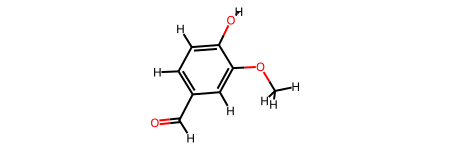

In [16]:
m